# Spain mobility Data 06/2020 DISTRITOS

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import geopandas as gpd

We analyse two different datasets, **maestra1** and **maestra2**, for Spain mobility data during June 2020 (easing of Covid restrictions) dealing with **districs** as spatial units.

Maestra1 provides hourly info about specific travels from 'origen' to 'destino'.

Maestra2 provides daily global info about number of travels from\to a specific district 

# Maestra1

In [11]:
df = pd.DataFrame([])
# days from 1 to 9
for i in range(1,10):
    path = f'maestra1/municipios/dias/2020060{i}_maestra_1_mitma_municipio.txt.gz'
    df1 = pd.read_csv(path, compression='gzip', header=0, sep='|', quotechar='"', on_bad_lines='skip')
    df1 = df1.rename(columns={'fecha': 'day'})
    df1['day'] = i
    df = pd.concat([df, df1], ignore_index=True)
# days from 10 to 30
for i in range(10,31):
    path = f'maestra1/municipios/dias/202006{i}_maestra_1_mitma_municipio.txt.gz'
    df1 = pd.read_csv(path, compression='gzip', header=0, sep='|', quotechar='"', on_bad_lines='skip')
    df1 = df1.rename(columns={'fecha': 'day'})
    df1['day'] = i
    df = pd.concat([df, df1], ignore_index=True)

In [12]:
print(df['distancia'].unique())

['002-005' '005-010' '010-050' '0005-002' '050-100' '100+']


Periodo: hour of the day

Distancia: range of km

Origen\Destino: code for the polygon (shapefile) that represents a spanish district

In [13]:
# add dummy variable weekends
df['weekend'] = [0 for _ in range(len(df))]
weekends = [6, 13, 20, 27, 7, 14, 21, 28]
cond = df['day'].isin(weekends)
df.loc[cond, 'weekend'] = 1

In [14]:
print(df.head(15))
print(df.info())

    day    origen   destino  periodo distancia  viajes  viajes_km  weekend
0     1  01001_AM  01001_AM        0   002-005  31.904    147.625        0
1     1  01001_AM  01001_AM        0   005-010  29.294    195.605        0
2     1  01001_AM  01001_AM        0   010-050  18.305    225.574        0
3     1  01001_AM  01001_AM        1   002-005  17.785     72.211        0
4     1  01001_AM  01001_AM        1   005-010  21.103    160.270        0
5     1  01001_AM  01001_AM        1   010-050   6.431     85.739        0
6     1  01001_AM  01001_AM        2   005-010  36.193    230.276        0
7     1  01001_AM  01001_AM        2   010-050  18.942    240.128        0
8     1  01001_AM  01001_AM        3   005-010  23.416    158.227        0
9     1  01001_AM  01001_AM        3   010-050   4.634     47.114        0
10    1  01001_AM  01001_AM        4   002-005  34.118    114.821        0
11    1  01001_AM  01001_AM        4   005-010  26.819    200.161        0
12    1  01001_AM  01001_

## Madrid Analysis

**GOAL**: compare the first (6-7 June) and the last weekend (27-28 June). Where are the most common destinations from Madrid in the distance range of more than 50km?

In [72]:
madrid_code = '28079'
df_first = df[(df['distancia'].isin(['050-100', '100+'])) & (df['origen'] == madrid_code) & (df['day'].isin([6, 7]))].reset_index().drop(columns=['index', 'origen', 'weekend'])
df_first.head(15)

,day,destino,periodo,distancia,viajes,viajes_km
0,6,01031_AM,3,100+,9.180,2473.797
1,6,01036,0,100+,5.581,1707.911
2,6,01036,2,100+,9.615,2938.890
3,6,01036,3,100+,5.652,1777.387
4,6,01051,9,100+,15.274,4503.043
5,6,01051,10,100+,15.274,4509.338
6,6,01059,3,100+,8.001,2240.151
7,6,01059,6,100+,7.793,2150.954
8,6,01059,11,100+,11.039,3021.447
9,6,01059,12,100+,11.039,3030.784


In [ ]:
gdf = gpd.read_file('zonificacion-municipios/municipios_mitma.shp')

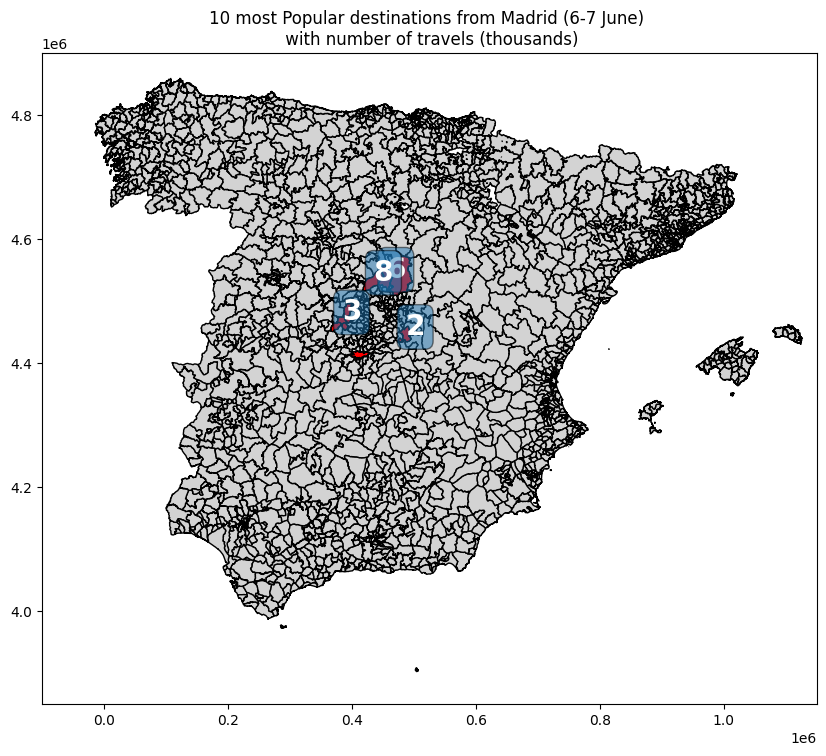

<Figure size 640x480 with 0 Axes>

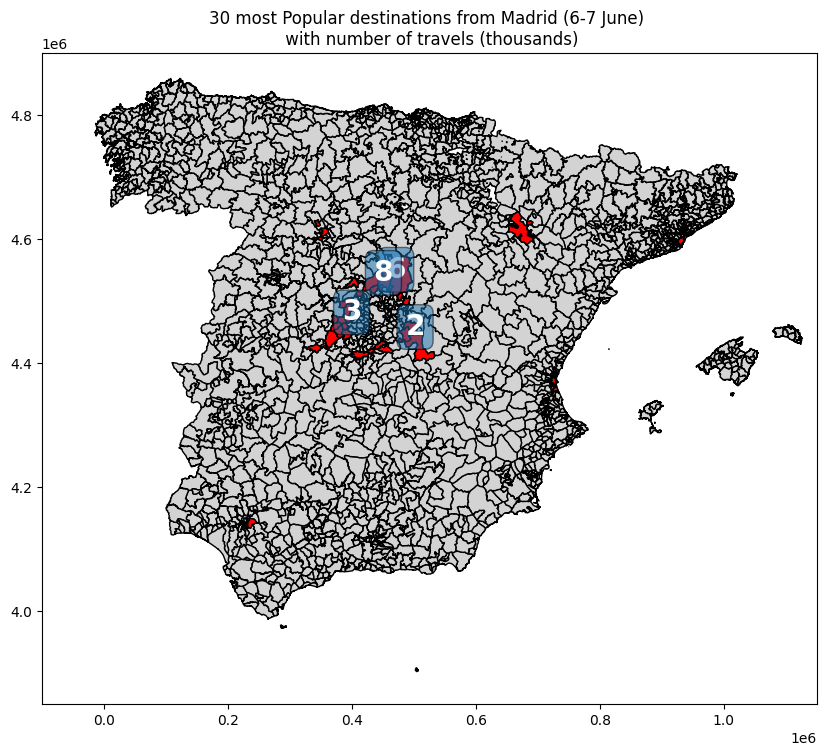

<Figure size 640x480 with 0 Axes>

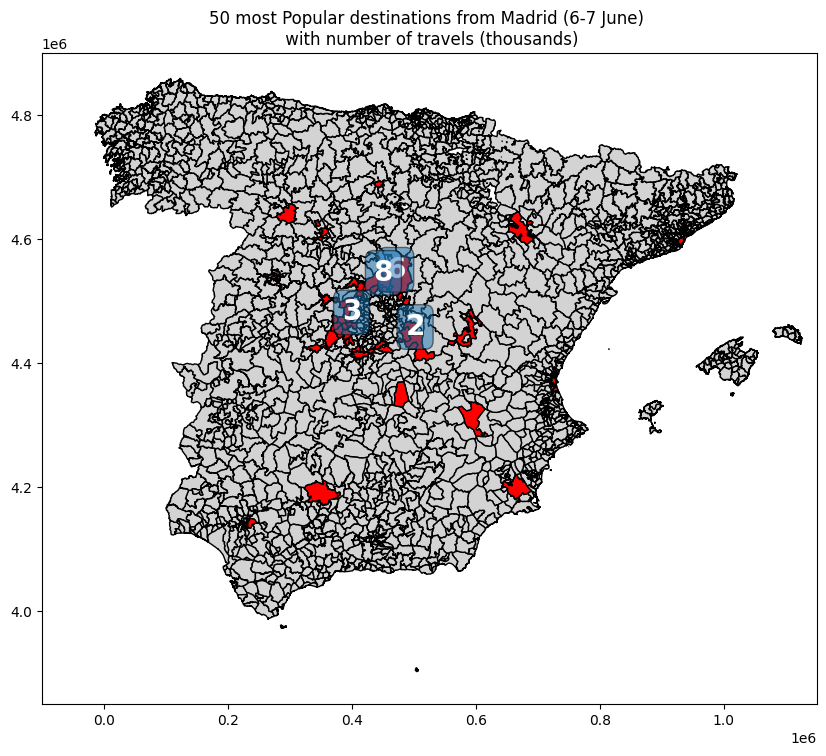

<Figure size 640x480 with 0 Axes>

In [121]:
df_first_sum = df_first[['viajes', 'viajes_km', 'destino']].groupby(['destino']).sum().reset_index()
df_first_sum.head()
sorted_df = df_first_sum.sort_values(by='viajes', ascending=False)
for n_popular in range(10, 60, 20):
    most_popular = sorted_df.head(n_popular).reset_index().drop('index', axis=1)
    most_popular['origen'] = madrid_code
    merged_df = gdf.merge(most_popular, left_on='ID', right_on='destino', how='right')
    merged_df['viajes_prop'] = merged_df['viajes']/merged_df['viajes'][0]
    merged_df['viajes'] = round(merged_df['viajes']* 1e-3).astype(int)
    fig, ax = plt.subplots(figsize=(10, 10))
    gdf.plot(ax=ax, color='lightgray', edgecolor='k')

    merged_df.plot(ax=ax, color='red', edgecolor='k')

    n_print = 4
    # Annotate the map with information from the merged DataFrame
    for x, y, label in zip(merged_df.geometry.centroid.x[:n_print][::-1], merged_df.geometry.centroid.y[:n_print][::-1], merged_df['viajes'][:n_print][::-1]):
        plt.text(x, y, label, fontsize=20, color='white', fontweight='bold', bbox=dict(boxstyle='round', alpha=0.5))

    plt.xlim([-0.1 * 1e6, 1.15 * 1e6])
    plt.ylim([3.85 * 1e6, 4.9 * 1e6])
    plt.title(f'{n_popular} most Popular destinations from Madrid (6-7 June) \n with number of travels (thousands)')
    plt.show()
    plt.savefig(f'figures/{n_popular}_destinations_6_7_june.png')

In [ ]:
# #### PLOT WITH ARROWS

# # from shapely.geometry import Point

# # Your GeoPandas DataFrame
# # Assuming your dataframe is named 'gdf'
# # Assuming your centroids dataframe is named 'centroids_df'
# # Replace these names with your actual dataframe names

# # Extract geometries for 'origen' (code 28079) and 'destino'
# origen_geometry = gdf[gdf['ID'] == '28079']['geometry'].reset_index().centroid
# destino_geometry = merged_df['geometry'].centroid

# # Create a GeoDataFrame for centroids
# centroids_df = gpd.GeoDataFrame(geometry=pd.concat([destino_geometry, origen_geometry]))

# # Add the 'viajes' column to the centroids_df
# # centroids_df['viajes'] = [merged_df['viajes'].sum(), merged_df['viajes'].sum()]

# # Plot the map with arrows
# fig, ax = plt.subplots(figsize=(12, 8))
# gdf.plot(ax=ax, color='lightgray')  # Plot the background map
# centroids_df.plot(ax=ax, color='red', markersize=centroids_df['viajes'], alpha=0.7)

# # Plot arrows
# for i, row in centroids_df.iterrows():
#     plt.arrow(row['geometry'].x, row['geometry'].y, 0, 0, color='black', width=0.001, alpha=0.5)

# plt.title('Arrows from Centroid of origen to Centroid of destino')
# plt.show()

Now check the weekend of the 27-28 June, last weekend of June:

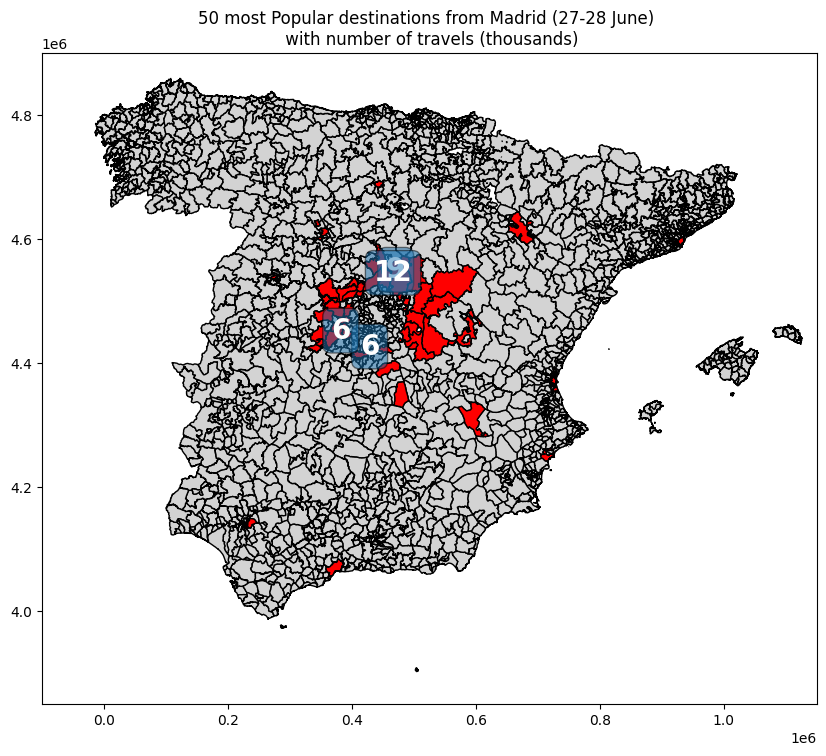

In [116]:
madrid_code = '28079'
df_last = df[(df['distancia'].isin(['050-100', '100+'])) & (df['origen'] == madrid_code) & (df['day'].isin([27, 28]))].reset_index().drop(columns=['index', 'origen', 'weekend'])
df_last_sum = df_last[['viajes', 'viajes_km', 'destino']].groupby(['destino']).sum().reset_index()
df_last_sum.head()
sorted_df = df_last_sum.sort_values(by='viajes', ascending=False)

n_popular = 50
most_popular = sorted_df.head(n_popular).reset_index().drop('index', axis=1)
most_popular['origen'] = madrid_code
merged_df = gdf.merge(most_popular, left_on='ID', right_on='destino', how='right')
merged_df['viajes_prop'] = merged_df['viajes']/merged_df['viajes'][0]
merged_df['viajes'] = round(merged_df['viajes']* 1e-3).astype(int)
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color='lightgray', edgecolor='k')

merged_df.plot(ax=ax, color='red', edgecolor='k')

n_print = 4
# Annotate the map with information from the merged DataFrame
for x, y, label in zip(merged_df.geometry.centroid.x[:n_print][::-1], merged_df.geometry.centroid.y[:n_print][::-1], merged_df['viajes'][:n_print][::-1]):
    plt.text(x, y, label, fontsize=20, color='white', fontweight='bold', bbox=dict(boxstyle='round', alpha=0.5))

plt.xlim([-0.1 * 1e6, 1.15 * 1e6])
plt.ylim([3.85 * 1e6, 4.9 * 1e6])
plt.title(f'{n_popular} most Popular destinations from Madrid (27-28 June) \n with number of travels (thousands)')
plt.show()

## Global Analysis

**Infer spanish habits**. which hour of the day are most of viajes? plot avg number viajes per hour

In [41]:
# divide between workdays and weekends:
weekends = [6, 13, 20, 27, 7, 14, 21, 28]
df_weekend = df[df['day'].isin(weekends)][['viajes', 'viajes_km', 'day', 'periodo']].groupby(['day', 'periodo']).sum()
hours = df['periodo'].unique()

# df_weekend = df_weekend.groupby(['periodo']).mean()
# avgs_weekend = df_weekend['viajes'].values
print(df_weekend.groupby(level=['periodo']).mean())

               viajes     viajes_km
periodo                            
0        3.517493e+06  2.019656e+07
1        2.601524e+06  1.477113e+07
2        1.908620e+06  1.147486e+07
3        1.489728e+06  1.000203e+07
4        1.326195e+06  1.068172e+07
5        1.494996e+06  1.455716e+07
6        1.893628e+06  2.030220e+07
7        2.434703e+06  2.615019e+07
8        3.084784e+06  3.252369e+07
9        3.914856e+06  4.016336e+07
10       4.725860e+06  4.765166e+07
11       5.495989e+06  5.410288e+07
12       6.002504e+06  5.615744e+07
13       6.118277e+06  5.392101e+07
14       5.232817e+06  4.580055e+07
15       4.456511e+06  4.380064e+07
16       4.568177e+06  4.854936e+07
17       4.957058e+06  5.294285e+07
18       5.491400e+06  5.603886e+07
19       5.968662e+06  5.641345e+07
20       6.061720e+06  5.148348e+07
21       5.695227e+06  4.247299e+07
22       4.715721e+06  3.161568e+07
23       3.141196e+06  1.735043e+07


In [42]:
df_weekend_mean_hour = df_weekend.groupby(level=['periodo']).mean()
avgs_weekend = df_weekend_mean_hour['viajes'].values
print(df_weekend_mean_hour.head())

               viajes     viajes_km
periodo                            
0        3.517493e+06  2.019656e+07
1        2.601524e+06  1.477113e+07
2        1.908620e+06  1.147486e+07
3        1.489728e+06  1.000203e+07
4        1.326195e+06  1.068172e+07


In [43]:
df_work = df[~df['day'].isin(weekdays)][['viajes', 'viajes_km', 'day', 'periodo']].groupby(['day', 'periodo']).sum()
df_work = df_work.groupby(level=['periodo']).mean()
avgs_work = df_work['viajes'].values

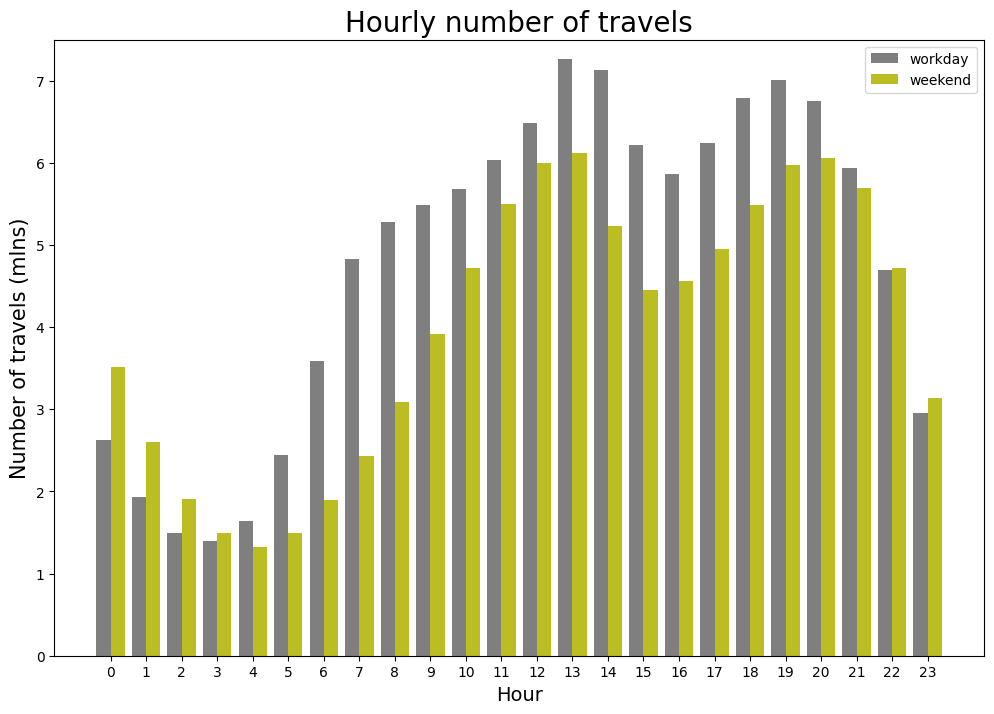

In [44]:
plt.figure(figsize=(12,8))
X_axis = np.arange(len(hours))
  
plt.bar(X_axis - 0.2, avgs_work*1e-6, 0.4, label = 'workday', color='tab:grey')
plt.bar(X_axis + 0.2, avgs_weekend*1e-6, 0.4, color='tab:olive', label='weekend')
plt.xlabel('Hour', fontsize=14)
plt.xticks(hours)
plt.ylabel('Number of travels (mlns)', fontsize=15)
plt.title('Hourly number of travels', fontsize=20)
plt.legend()
plt.ylim(top=7.5)

plt.show()

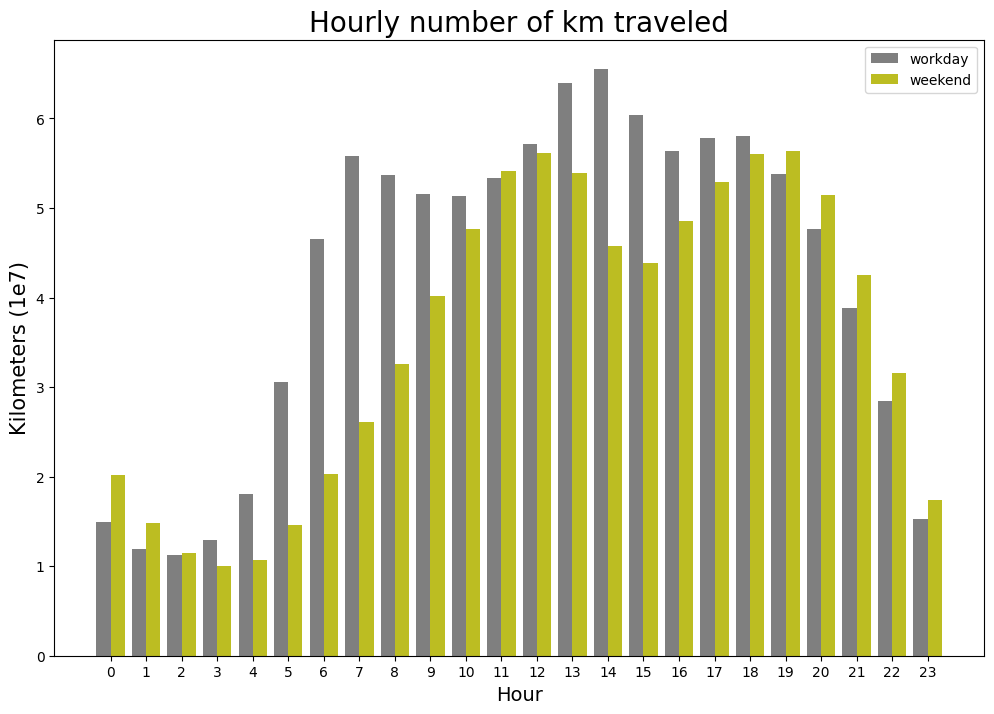

In [45]:
# same with viajes_km
avgs_weekend = df_weekend_mean_hour['viajes_km'].values
avgs_work = df_work['viajes_km'].values
plt.figure(figsize=(12,8))
X_axis = np.arange(len(hours))
  
plt.bar(X_axis - 0.2, avgs_work*1e-7, 0.4, label = 'workday', color='tab:grey')
plt.bar(X_axis + 0.2, avgs_weekend*1e-7, 0.4, color='tab:olive', label='weekend')
plt.xlabel('Hour', fontsize=14)
plt.xticks(hours)
plt.ylabel('Kilometers (1e7)', fontsize=15)
plt.title('Hourly number of km traveled', fontsize=20)
plt.legend()

plt.show()

TODO: use distancia label encoder, find which travels are internal/external

In [34]:
group_distancia = df.groupby(['distancia', 'day']).sum()
print(group_distancia.head())

               periodo        viajes     viajes_km  weekend  external
distancia day                                                        
0005-002  1    1019148  3.836383e+07  4.551382e+07        0     47982
          2    1022750  3.925588e+07  4.655733e+07        0     48475
          3    1021510  3.907852e+07  4.637213e+07        0     48352
          4    1016425  3.876002e+07  4.600749e+07        0     48267
          5    1028134  4.056766e+07  4.819318e+07        0     48541


In [35]:
group_distancia.info()
# print(distances)
# for g in distances:
#     df_g = group_distancia.get_group(g)
group_distancia.loc[('100+', 1)]

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 180 entries, ('0005-002', 1) to ('100+', 30)
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   periodo    180 non-null    int64  
 1   viajes     180 non-null    float64
 2   viajes_km  180 non-null    float64
 3   weekend    180 non-null    int64  
 4   external   180 non-null    int64  
dtypes: float64(2), int64(3)
memory usage: 7.8+ KB


periodo      7.646180e+05
viajes       6.169966e+05
viajes_km    1.327108e+08
weekend      0.000000e+00
external     6.824800e+04
Name: (100+, 1), dtype: float64

In [36]:
print(df.iloc[0:15])

    day    origen   destino  periodo distancia  viajes  viajes_km  weekend  \
0     1  01001_AM  01001_AM        0   002-005  31.904    147.625        0   
1     1  01001_AM  01001_AM        0   005-010  29.294    195.605        0   
2     1  01001_AM  01001_AM        0   010-050  18.305    225.574        0   
3     1  01001_AM  01001_AM        1   002-005  17.785     72.211        0   
4     1  01001_AM  01001_AM        1   005-010  21.103    160.270        0   
5     1  01001_AM  01001_AM        1   010-050   6.431     85.739        0   
6     1  01001_AM  01001_AM        2   005-010  36.193    230.276        0   
7     1  01001_AM  01001_AM        2   010-050  18.942    240.128        0   
8     1  01001_AM  01001_AM        3   005-010  23.416    158.227        0   
9     1  01001_AM  01001_AM        3   010-050   4.634     47.114        0   
10    1  01001_AM  01001_AM        4   002-005  34.118    114.821        0   
11    1  01001_AM  01001_AM        4   005-010  26.819    200.16

Plot time series for each category of 'distancia':

In [37]:
df_work = df[~df['day'].isin(weekdays)].groupby(['day', 'periodo', 'distancia']).sum()
df_work = df_work.groupby(level=['periodo', 'distancia'] ).mean()

In [38]:
# # proof that calculations were right
# print(df_work.groupby(level=['periodo'] ).sum()['viajes'].values)
# print(avgs_work)

In [39]:
print(df_work.head())

                         viajes     viajes_km  weekend      external
periodo distancia                                                   
0       0005-002   1.170493e+06  1.365058e+06      0.0   1907.954545
        002-005    7.358067e+05  2.351090e+06      0.0   5492.090909
        005-010    4.096664e+05  2.882489e+06      0.0   9132.227273
        010-050    2.846550e+05  5.063306e+06      0.0  15295.590909
        050-100    1.384953e+04  9.266733e+05      0.0   1517.409091


In [40]:
df['distancia'].unique()

array(['002-005', '005-010', '010-050', '0005-002', '050-100', '100+'],
      dtype=object)

In [41]:
# create dictionary of distancia
dist_category = df['distancia'].unique()
prop_dict = dict.fromkeys(hours, None)
for j in hours:
    df_hour = df_work.loc[j,:]
    prop = []
    # for each hour save a list of 6 values, representing the travels in each of the 6 categories
    for i in dist_category:
        l = df_hour.loc[i]['viajes']
        prop.append(l)
    prop_dict[j] = prop

24


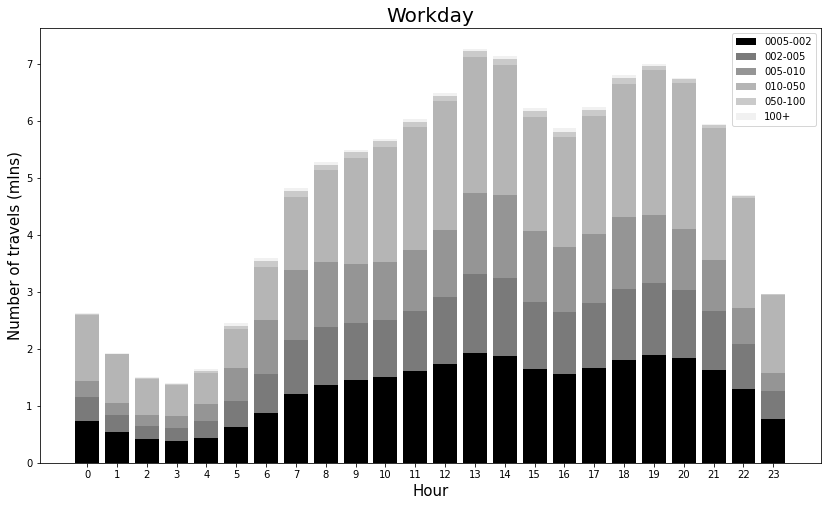

In [42]:
zero = []
one = []
two = []
three = []
four = []
five = []
six = []
for d in hours:
    zero.append(prop_dict[d][0]*1e-6)
    one.append(prop_dict[d][1]*1e-6)
    two.append(prop_dict[d][2]*1e-6)
    three.append(prop_dict[d][3]*1e-6)
    four.append(prop_dict[d][4]*1e-6)
    five.append(prop_dict[d][5]*1e-6)
print(len(four))

b_two = list(np.add(zero, one))
b_three = list(np.add(b_two, two))
b_four = list(np.add(b_three, three))
b_five =  list(np.add(b_four, four))
b_six =  list(np.add(b_five, five))


c = np.arange(1, 6 + 1)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Greys)
cmap.set_array([])


plt.figure(figsize=(14,8))
plt.bar(hours, zero, label='0005-002', color = cmap.to_rgba(6))
plt.bar(hours, one, bottom=zero, label='002-005', color=cmap.to_rgba(4))
plt.bar(hours, two, bottom=b_two, label='005-010', color=cmap.to_rgba(3.5))
plt.bar(hours, three, bottom=b_three, label='010-050', color=cmap.to_rgba(3))
plt.bar(hours, four, bottom=b_four, label='050-100', color=cmap.to_rgba(2.6))
plt.bar(hours, five, bottom=b_five, label='100+', color=cmap.to_rgba(1.6))


plt.xlabel('Hour', fontsize=15)
plt.ylabel('Number of travels (mlns)', fontsize=15)
plt.legend()
plt.title('Workday', fontsize=20)
plt.xticks(hours)
plt.savefig('figures/number_travels_hist.png')
plt.show()

24


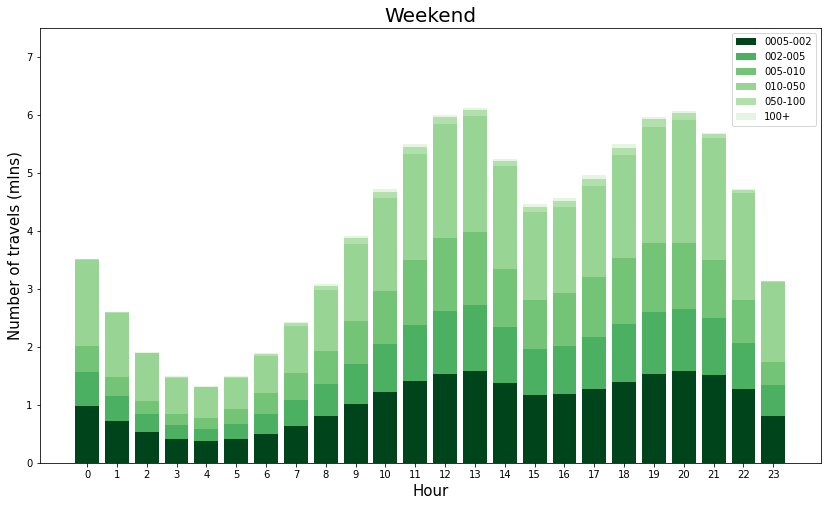

In [43]:
# same for weekends:
df_weekend = df[df['day'].isin(weekdays)].groupby(['day', 'periodo', 'distancia']).sum()
df_weekend  = df_weekend .groupby(level=['periodo', 'distancia'] ).mean()
# create dictionary of distancia
prop_dict = dict.fromkeys(hours, None)
for j in hours:
    df_hour = df_weekend.loc[j,:]
    prop = []
    # for each hour save a list of 6 values, representing the travels in each of the 6 categories
    for i in dist_category:
        l = df_hour.loc[i]['viajes']
        prop.append(l)
    prop_dict[j] = prop
zero = []
one = []
two = []
three = []
four = []
five = []
six = []
for d in hours:
    zero.append(prop_dict[d][0]*1e-6)
    one.append(prop_dict[d][1]*1e-6)
    two.append(prop_dict[d][2]*1e-6)
    three.append(prop_dict[d][3]*1e-6)
    four.append(prop_dict[d][4]*1e-6)
    five.append(prop_dict[d][5]*1e-6)
print(len(four))

b_two = list(np.add(zero, one))
b_three = list(np.add(b_two, two))
b_four = list(np.add(b_three, three))
b_five =  list(np.add(b_four, four))
b_six =  list(np.add(b_five, five))


c = np.arange(1, 6 + 1)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Greens)
cmap.set_array([])


plt.figure(figsize=(14,8))
plt.bar(hours, zero, label='0005-002', color = cmap.to_rgba(6))
plt.bar(hours, one, bottom=zero, label='002-005', color=cmap.to_rgba(4))
plt.bar(hours, two, bottom=b_two, label='005-010', color=cmap.to_rgba(3.5))
plt.bar(hours, three, bottom=b_three, label='010-050', color=cmap.to_rgba(3))
plt.bar(hours, four, bottom=b_four, label='050-100', color=cmap.to_rgba(2.6))
plt.bar(hours, five, bottom=b_five, label='100+', color=cmap.to_rgba(1.6))


plt.xlabel('Hour', fontsize=15)
plt.ylabel('Number of travels (mlns)', fontsize=15)
plt.legend()
plt.title('Weekend', fontsize=20)
plt.xticks(hours)
plt.ylim(top=7.5)
plt.savefig('figures/number_travels_hist.png')
plt.show()

Now do the averages by hour and cosider daily time series:

In [44]:
df_series = df.groupby(['day', 'distancia']).sum()
df_series.head()

periodo        viajes     viajes_km  weekend  external
day distancia                                                        
1   0005-002   1019148  3.836383e+07  4.551382e+07        0     47982
    002-005    2241843  2.872986e+07  9.306125e+07        0    142897
    005-010    3663136  1.933333e+07  1.376809e+08        0    264085
    010-050    8066432  1.890788e+07  3.635191e+08        0    633179
    050-100    1397837  1.334207e+06  8.926232e+07        0    117544

30


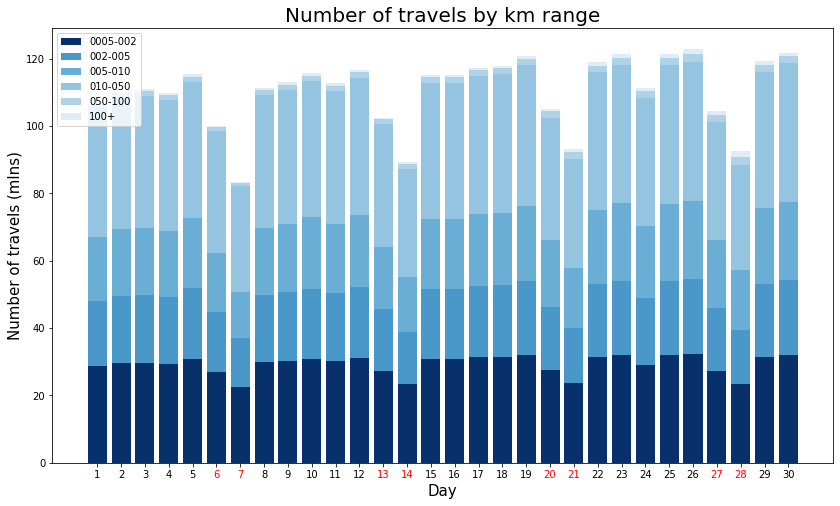

In [45]:
# create dictionary of distancia
days = df['day'].unique()
prop_dict = dict.fromkeys(days, None)
for j in days:
    df_day = df_series.loc[j,:]
    prop = []
    # for each hour save a list of 6 values, representing the travels in each of the 6 categories
    for i in dist_category:
        l = df_day.loc[i]['viajes']
        prop.append(l)
    prop_dict[j] = prop
zero = []
one = []
two = []
three = []
four = []
five = []
six = []
for d in days:
    zero.append(prop_dict[d][0]*1e-6)
    one.append(prop_dict[d][1]*1e-6)
    two.append(prop_dict[d][2]*1e-6)
    three.append(prop_dict[d][3]*1e-6)
    four.append(prop_dict[d][4]*1e-6)
    five.append(prop_dict[d][5]*1e-6)
print(len(four))

b_two = list(np.add(zero, one))
b_three = list(np.add(b_two, two))
b_four = list(np.add(b_three, three))
b_five =  list(np.add(b_four, four))
b_six =  list(np.add(b_five, five))


c = np.arange(1, 6 + 1)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
cmap.set_array([])



fig, ax = plt.subplots(figsize=(14,8))
ax.bar(days, zero, label='0005-002', color = cmap.to_rgba(6))
ax.bar(days, one, bottom=zero, label='002-005', color=cmap.to_rgba(4))
ax.bar(days, two, bottom=b_two, label='005-010', color=cmap.to_rgba(3.5))
ax.bar(days, three, bottom=b_three, label='010-050', color=cmap.to_rgba(3))
ax.bar(days, four, bottom=b_four, label='050-100', color=cmap.to_rgba(2.6))
ax.bar(days, five, bottom=b_five, label='100+', color=cmap.to_rgba(1.6))


ax.set_xlabel('Day', fontsize=15)
ax.set_ylabel('Number of travels (mlns)', fontsize=15)
plt.legend(loc='upper left')
ax.set_title('Number of travels by km range', fontsize=20)
ax.set_xticks(days)
for i in weekdays:
    ax.get_xticklabels()[i-1].set_color("red")
plt.show()

<Figure size 864x576 with 0 Axes>

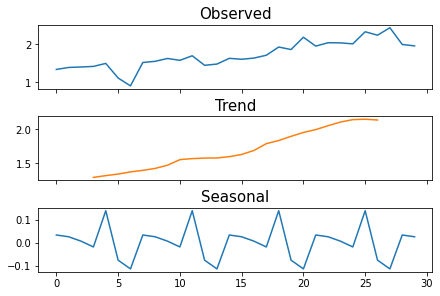

In [46]:
result = seasonal_decompose(four, model='additive', period=7)

plt.figure(figsize=(12,8))
fig, axs = plt.subplots(3, sharex=True, constrained_layout = True)
axs[0].plot(four)
axs[0].set_title('Observed', fontsize=15)
axs[1].plot(result.trend, color='tab:orange')
axs[1].set_title('Trend', fontsize=15)
axs[2].plot(result.seasonal)
axs[2].set_title('Seasonal', fontsize=15)
plt.show()

In [ ]:
# Add variable 'external' (if the travel is internal or external):
# TODO: When origen!=destino, which are the most popular destinations? how many internal travels? how many external?

v = 1*(df['origen']!=df['destino']).values
df['external'] = v
df.head()
df_int = df.groupby(['day', 'external']).sum()
# create dictionary of distancia
days = df['day'].unique()
category = df['external'].unique()
prop_dict = dict.fromkeys(days, None)
for j in days:
    df_day = df_int.loc[j,:]
    prop = []
    # for each hour save a list of 6 values, representing the travels in each of the 6 categories
    for i in category:
        l = df_day.loc[i]['viajes']
        prop.append(l)
    prop_dict[j] = prop
zero = []
one = []
for d in days:
    zero.append(prop_dict[d][0]*1e-6)
    one.append(prop_dict[d][1]*1e-6)

b_two = list(np.add(zero, one))
c = np.arange(1, 6 + 1)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
cmap.set_array([])
fig, ax = plt.subplots(figsize=(14,8))
ax.bar(days, zero, label='internal', color = cmap.to_rgba(6))
ax.bar(days, one, bottom=zero, label='external', color=cmap.to_rgba(4))

ax.set_xlabel('Day', fontsize=15)
ax.set_ylabel('Number of travels (mlns)', fontsize=15)
plt.legend(loc='upper left')
ax.set_title('Number of internal/external travels ', fontsize=20)
ax.set_xticks(days)
for i in weekdays:
    ax.get_xticklabels()[i-1].set_color("red")
plt.show()

In [ ]:
# Now plot daily average of viajes int/ext in the most popolous cities:
df_city = df.loc[df['origen'].isin(best_muni)]
df_city = df_city.groupby(['origen', 'external', 'day']).sum()
df_city.head()

prop_dict = dict.fromkeys(best_muni, None)
for code in best_muni:
    m = []
    for c in category:
        df_tmp = df_city.loc[code, c, :]
        m.append(df_tmp.mean()['viajes'])
    m = np.array(m) / np.sum(m)
    prop_dict[code] = m

zero = []
one = []
for d in best_muni:
    zero.append(prop_dict[d][0])
    one.append(prop_dict[d][1])

b_two = list(np.add(zero, one))
c = np.arange(1, 6 + 1)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
cmap.set_array([])
fig, ax = plt.subplots(figsize=(14,8))
ax.bar(best_names, zero, label='internal', color = cmap.to_rgba(6))
ax.bar(best_names, one, bottom=zero, label='external', color=cmap.to_rgba(4))

ax.set_xlabel('City', fontsize=15)
plt.legend(loc='upper left')
ax.set_title('Proportion of internal/external travels ', fontsize=20)
ax.set_xticks(best_names)
plt.show()

# Maestra2

Load and merge the daily data altogether:

In [3]:
df2 = pd.DataFrame([])
# days from 1 to 10
for i in range(1,10):
    path = f'maestra2/municipios/2020060{i}_maestra_2_mitma_municipio.txt.gz'
    df1 = pd.read_csv(path, compression='gzip', header=0, sep='|', quotechar='"', on_bad_lines='skip')
    df1 = df1.rename(columns={'fecha': 'day'})
    df1['day'] = i
    df2 = pd.concat([df2, df1], ignore_index=True)
# days from 10 to 30
for i in range(10,31):
    path = f'maestra2/municipios/202006{i}_maestra_2_mitma_municipio.txt.gz'
    df1 = pd.read_csv(path, compression='gzip', header=0, sep='|', quotechar='"', on_bad_lines='skip')
    df1 = df1.rename(columns={'fecha': 'day'})
    df1['day'] = i
    df2 = pd.concat([df2, df1], ignore_index=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78832 entries, 0 to 78831
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   day            78832 non-null  int64  
 1   distrito       78832 non-null  object 
 2   numero_viajes  78832 non-null  object 
 3   personas       78832 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 2.4+ MB


Add boolean variable weekend and change distritos into municipios:

In [5]:
df2['weekend'] = [0 for _ in range(len(df2))]
weekdays = [6, 13, 20, 27, 7, 14, 21, 28]
cond = df2['day'].isin(weekdays)
df2.loc[cond, 'weekend'] = 1
df2 = df2.rename({'distrito': 'municipio'}, axis=1)
print(df2.info()) # no missing values
#check for duplicates
print(df2.duplicated().sum())
print(df2.head())

How many people are considered? 46,450,000

In [8]:
cond = df2['day']==12
print(round(df2.loc[cond, 'personas'].sum(), 0))

46455277.93399999

## Global analysis of Spain

Proportion of people who traveled 0,1,2,2+ times during each day:

In [9]:
# create dictionary of proportions
n_viajes = df2['numero_viajes'].unique()
days = [i for i in range(1,31)]
prop_dict = dict.fromkeys(days, None)
for j in days:
    df_day = df2.loc[df2['day']==j]
    prop = []
    for i in n_viajes:
        cond = df_day['numero_viajes']==i
        prop.append(df_day.loc[cond, 'personas'].sum())
    prop_dict[j] = prop


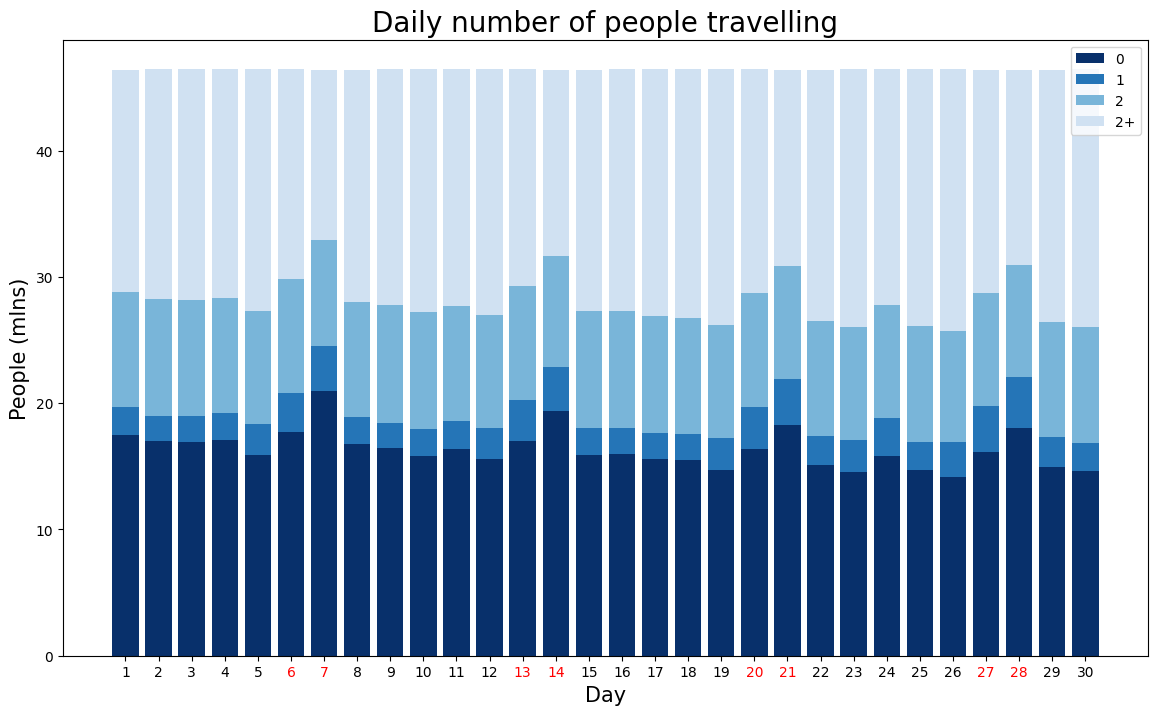

In [10]:
zero = []
one = []
two = []
two_plus = []
for d in days:
    zero.append(prop_dict[d][0]*1e-6)
    one.append(prop_dict[d][1]*1e-6)
    two.append(prop_dict[d][2]*1e-6)
    two_plus.append(prop_dict[d][3]*1e-6)
b_two = list(np.add(zero, one))
b_two_plus = list(np.add(b_two, two))

c = np.arange(1, 4 + 1)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
cmap.set_array([])



fig, ax = plt.subplots(figsize=(14,8))
ax.bar(days, zero, label='0', color = cmap.to_rgba(6))
ax.bar(days, one, bottom=zero, label='1', color=cmap.to_rgba(3.2))
ax.bar(days, two, bottom=b_two, label='2', color=cmap.to_rgba(2.4))
ax.bar(days, two_plus, bottom=b_two_plus, label='2+', color=cmap.to_rgba(1.6))


ax.set_xlabel('Day', fontsize=15)
ax.set_ylabel('People (mlns)', fontsize=15)
plt.legend()
ax.set_title('Daily number of people travelling', fontsize=20)
ax.set_xticks(days)
for i in weekdays:
    ax.get_xticklabels()[i-1].set_color("red")
plt.show()

<Figure size 1200x800 with 0 Axes>

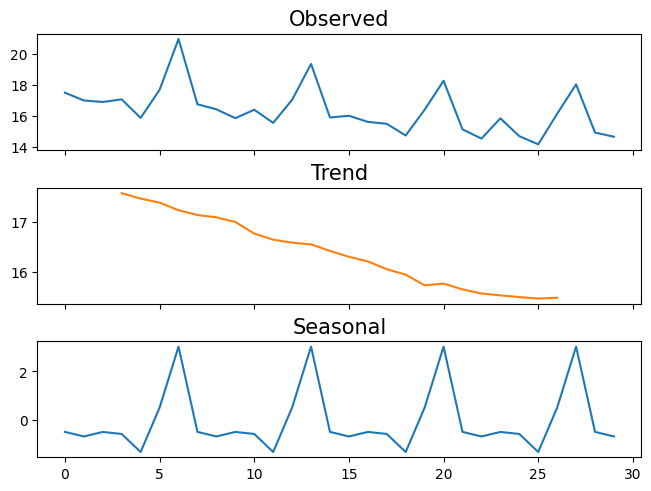

In [11]:
result = seasonal_decompose(zero, model='additive', period=7)

plt.figure(figsize=(12,8))
fig, axs = plt.subplots(3, sharex=True, constrained_layout = True)
axs[0].plot(zero)
axs[0].set_title('Observed', fontsize=15)
axs[1].plot(result.trend, color='tab:orange')
axs[1].set_title('Trend', fontsize=15)
axs[2].plot(result.seasonal)
axs[2].set_title('Seasonal', fontsize=15)
plt.show()

Boxplot of number of travels (ignoring the municipio):

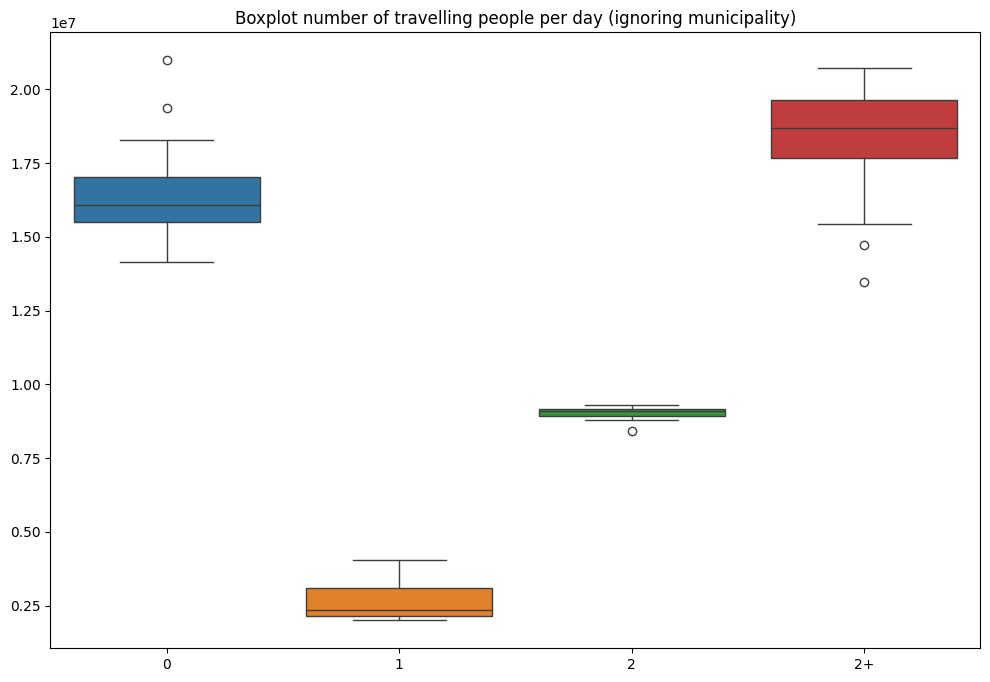

In [12]:
data = []
for d in days:
    x = prop_dict[d]
    data.append(x)
data = pd.DataFrame(data, columns = ['0', '1', '2', '2+'])
plt.figure(figsize=(12,8))
sns.boxplot(data)
plt.title('Boxplot number of travelling people per day (ignoring municipality)')
plt.show()

Differentiate between weekend or not:

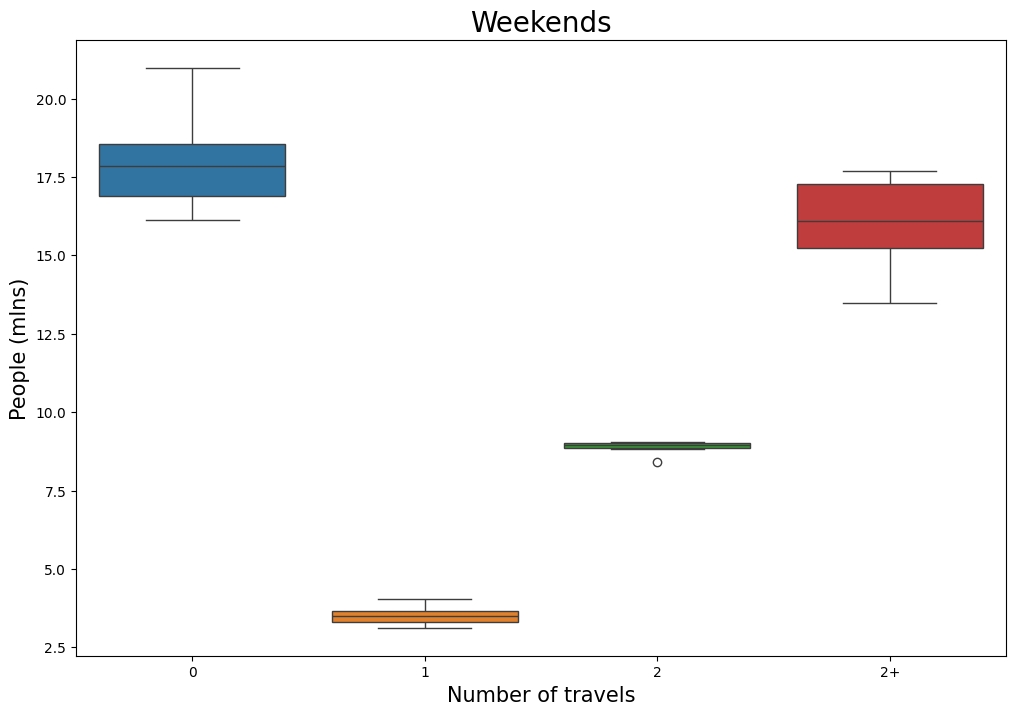

In [13]:
data_weekend = []
for d in days:
    if d in weekdays:
        x = [i*1e-6 for i in prop_dict[d]]
        data_weekend.append(x)
data_weekend = pd.DataFrame(data_weekend, columns = ['0', '1', '2', '2+'])
plt.figure(figsize=(12,8))
sns.boxplot(data_weekend)
plt.title('Weekends', fontsize=20)
plt.xlabel('Number of travels', fontsize=15)
plt.ylabel('People (mlns)', fontsize=15)
plt.show()

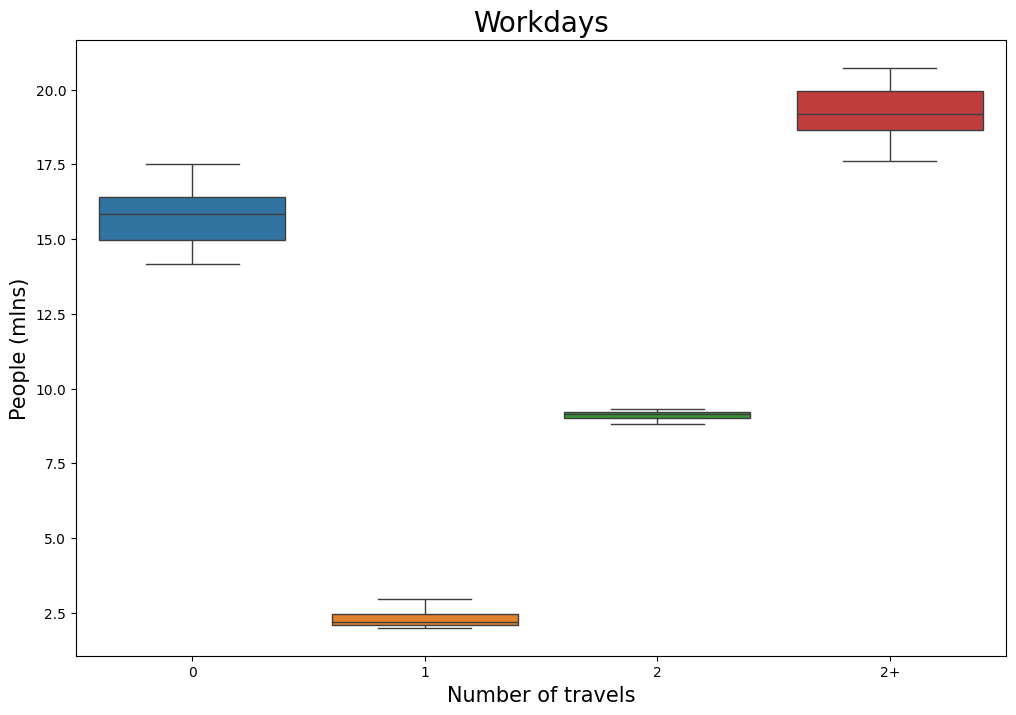

In [14]:
data = []
for d in days:
    if d not in weekdays:
        x = [i*1e-6 for i in prop_dict[d]]
        data.append(x)
data = pd.DataFrame(data, columns = ['0', '1', '2', '2+'])
plt.figure(figsize=(12,8))
sns.boxplot(data)
plt.title('Workdays', fontsize=20)
plt.xlabel('Number of travels', fontsize=15)
plt.ylabel('People (mlns)', fontsize=15)
plt.show()

In [15]:
print(data_weekend.mean().values)
print(data.mean().values)

[17.99087468  3.49904746  8.88811573 16.03727991]
[15.7702326   2.27995498  9.11218063 19.2726102 ]


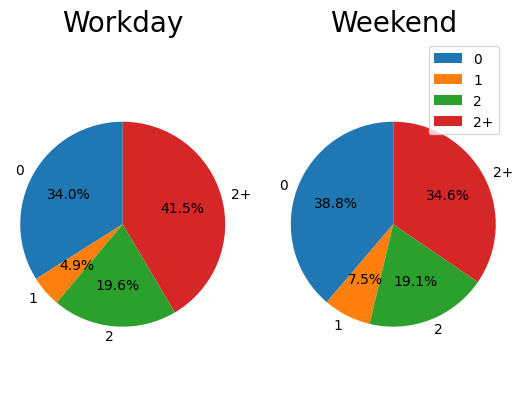

In [16]:
# Pie chart of the population divided in weekends or not
# where the slices will be ordered and plotted counter-clockwise:
labels = ['0', '1', '2', '2+']
size_weekend = data_weekend.mean().values
size_work = data.mean().values
explode = (0, 0, 0, 0)  # only "explode" the 2nd slice

fig, ax = plt.subplots(1,2)
ax[1].pie(size_weekend, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90)
ax[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax[1].set_title('Weekend', fontsize=20)
ax[0].pie(size_work, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90)
ax[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax[0].set_title('Workday', fontsize=20)
plt.legend()
plt.show()

## Analysis per municipality

Sort the municipalities w.r.t. the number of people and take the 10 most populous:

Number of municipalities: 2186
Number of people in each municipality: [0.00900917 0.01027354 0.00647092 ... 0.00566287 0.08313444 0.08122982]
Most populated municipalities: ['28079' '08019' '46250' '41091' '50297' '29067' '30030' '07040' '35016'
 '48020'] and their population [2.99618946 1.53280741 0.73114295 0.64507061 0.64392554 0.54934492
 0.41993833 0.39058316 0.3751612  0.32980363]


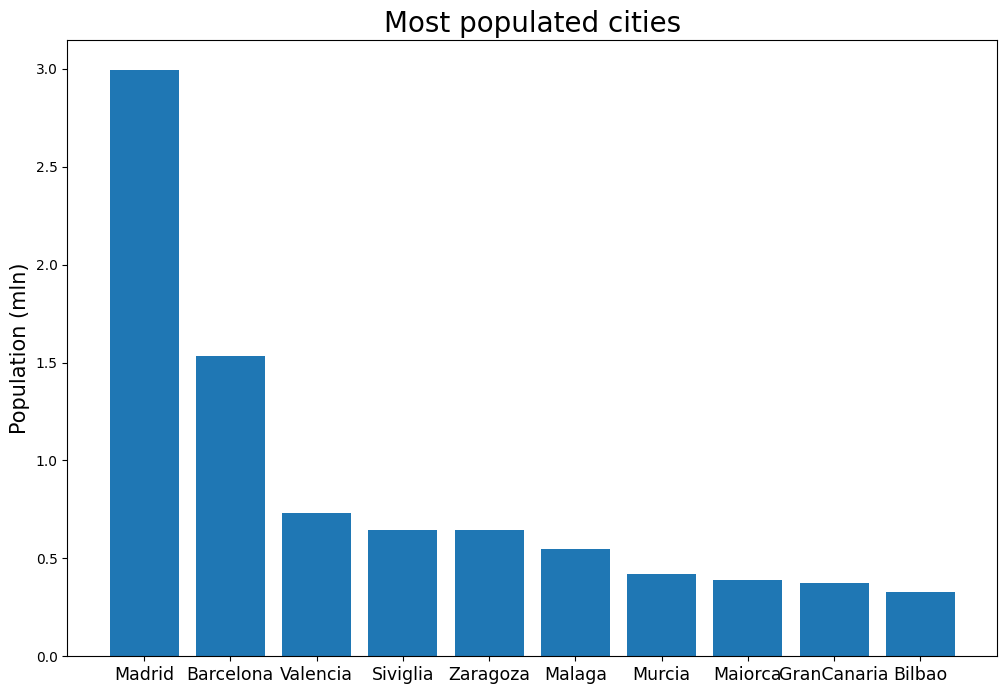

In [17]:
# use day 1 to calculate the TOTAL population in each municipality

municipios = df2.loc[df2['day']==1, 'municipio'].unique()
print(f'Number of municipalities: {len(municipios)}')

df_muni = df2.loc[df2['day']==1].groupby(by='municipio').sum()
df_muni = df_muni['personas'] * 1e-6
df_muni = df_muni.reset_index()
dict_total_personas = dict(df_muni)

n = df_muni['personas'].values
print(f'Number of people in each municipality: {n}')

# take the 10 most popolous cities

index = np.argsort(n)[::-1][:10]
best_muni = municipios[index]
best_names = ['Madrid', 'Barcelona', 'Valencia', 'Siviglia', 'Zaragoza', 'Malaga', 'Murcia', 'Maiorca', 'GranCanaria', 'Bilbao']
best_pop = n[index]
print(f'Most populated municipalities: {best_muni} and their population {best_pop}')
plt.figure(figsize = (12,8))
plt.bar(best_names, best_pop)
plt.ylabel('Population (mln)', fontsize=15)
plt.xticks(fontsize=12.5)
plt.title('Most populated cities', fontsize=20)
plt.show()

In [18]:
df_muni.head(10)
df_muni['personas'] = df_muni['personas'].round(2)
df_most_populated = df_muni[df_muni['personas'] >= 0.1]
first_10 = df_muni.sort_values(by='personas', ascending=False).head(10)

In [19]:
first_10 = first_10.reset_index(drop=True)

### Plot map of the municipalities with their population in millions

In [20]:
gdf = gpd.read_file('zonificacion-municipios/municipios_mitma.shp')
gdf = gdf.rename(columns ={'ID':'municipio'})
merged_df = gdf.merge(first_10.drop(8), on='municipio', how='right')
merged_df.head(10)

,municipio,geometry,personas
0,28079,"POLYGON ((444049.860 4464419.041, 443947.316 4...",3.00
1,08019,"MULTIPOLYGON (((924237.795 4597384.121, 924205...",1.53
2,46250,"MULTIPOLYGON (((726361.479 4378203.078, 726440...",0.73
3,41091,"MULTIPOLYGON (((231193.553 4132489.148, 231180...",0.65
4,50297,"MULTIPOLYGON (((656030.806 4598572.698, 655665...",0.64
5,29067,"MULTIPOLYGON (((386372.414 4071680.358, 386091...",0.55
6,30030,"MULTIPOLYGON (((671780.921 4176933.323, 671556...",0.42
7,07040,"MULTIPOLYGON (((1012215.815 4348948.313, 10121...",0.39
8,48020,"POLYGON ((504280.899 4785149.083, 504227.655 4...",0.33


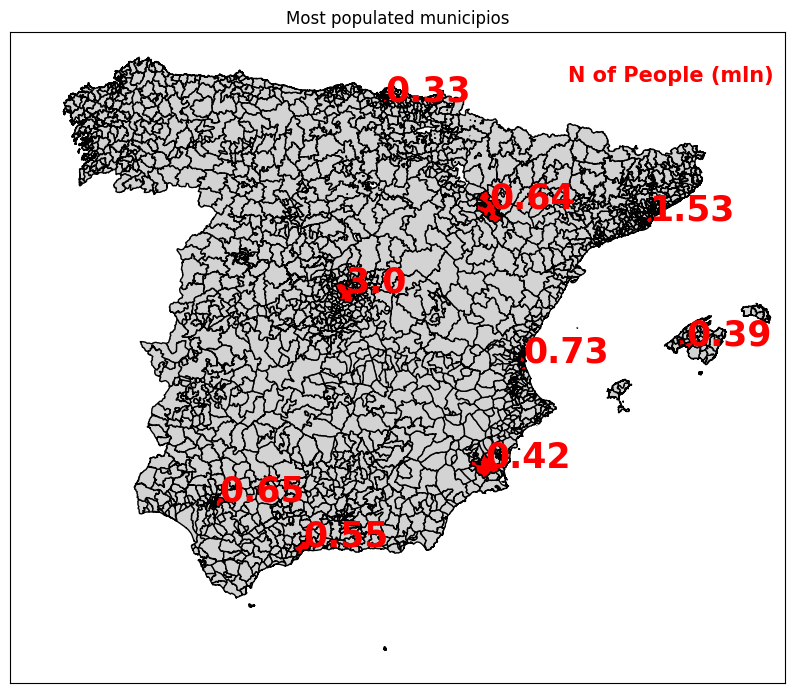

In [21]:
# # Plot the map
# condition = gdf.cx[:, -0.1:].plot

# # Apply the condition to select the geometries
# gdf_toplot = gdf[gdf.intersects(condition)]]

fig, ax = plt.subplots(figsize=(10, 10))
# ax.set_xlim(-0.1)  # Restrict the x-axis
# ax.set_ylim(3.8)
gdf.plot(ax=ax, color='lightgray', edgecolor='k')

merged_df.plot(ax=ax, color='red', edgecolor='k')

# Annotate the map with information from the merged DataFrame
for x, y, label in zip(merged_df.geometry.centroid.x, merged_df.geometry.centroid.y, merged_df['personas']):
    plt.text(x, y, label, fontsize=25, color='red', fontweight='bold')
    # ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords='offset points', color='red')

# Add a side label
side_label = "N of People (mln)"  # Modify this text as needed
plt.text(0.8 * 1e6, 4.82 * 1e6, side_label, fontsize=15, fontweight='bold', color='red')

plt.xlim([-0.1 * 1e6, 1.15 * 1e6])
plt.ylim([3.85 * 1e6, 4.9 * 1e6])
plt.title('Most populated municipios')
plt.savefig('figures/most_populated_map.png')
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  
plt.show()




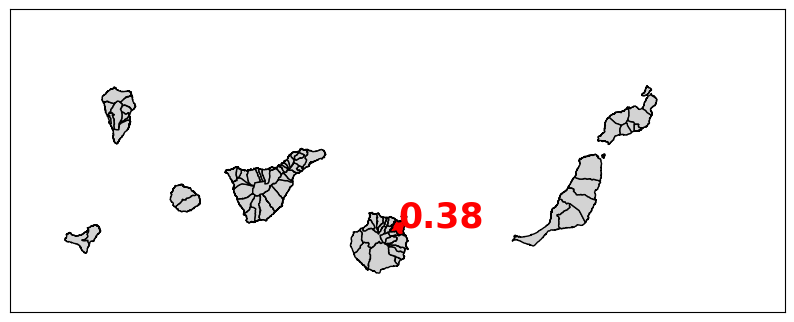

In [22]:
# Canaries

merged_df = gdf.merge(first_10.iloc[[8]], on='municipio', how='right')
merged_df.head(10)

fig, ax = plt.subplots(figsize=(10, 10))
# ax.set_xlim(-0.1)  # Restrict the x-axis
# ax.set_ylim(3.8)
gdf.plot(ax=ax, color='lightgray', edgecolor='k')

merged_df.plot(ax=ax, color='red', edgecolor='k')

# Annotate the map with information from the merged DataFrame
for x, y, label in zip(merged_df.geometry.centroid.x, merged_df.geometry.centroid.y, merged_df['personas']):
    plt.text(x, y, label, fontsize=25, color='red', fontweight='bold')
    # ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords='offset points', color='red')

# # Add a side label
# side_label = "N of People (mln)"  # Modify this text as needed
# plt.text(-0.65 * 1e6, 3.32 * 1e6, side_label, fontsize=15, fontweight='bold', color='red')

plt.xlim([-1.05 * 1e6, -0.41 * 1e6])
plt.ylim([3.1 * 1e6, 3.35 * 1e6])
# plt.title('Most populated municipios (Canary)')
plt.savefig('figures/most_populated_map_canary.png')
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  
plt.show()

Behaviour of different cities in mobility (average number of travels):

City: Madrid
               personas
numero_viajes          
0              0.369614
1              0.052863
2              0.194143
2+             0.383380


/var/folders/d3/rdvhjvc52n99n0pgdzgxgtph0000gq/T/ipykernel_2317/2445987698.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_muni['personas'] = df_muni['personas']/best_pop[i]


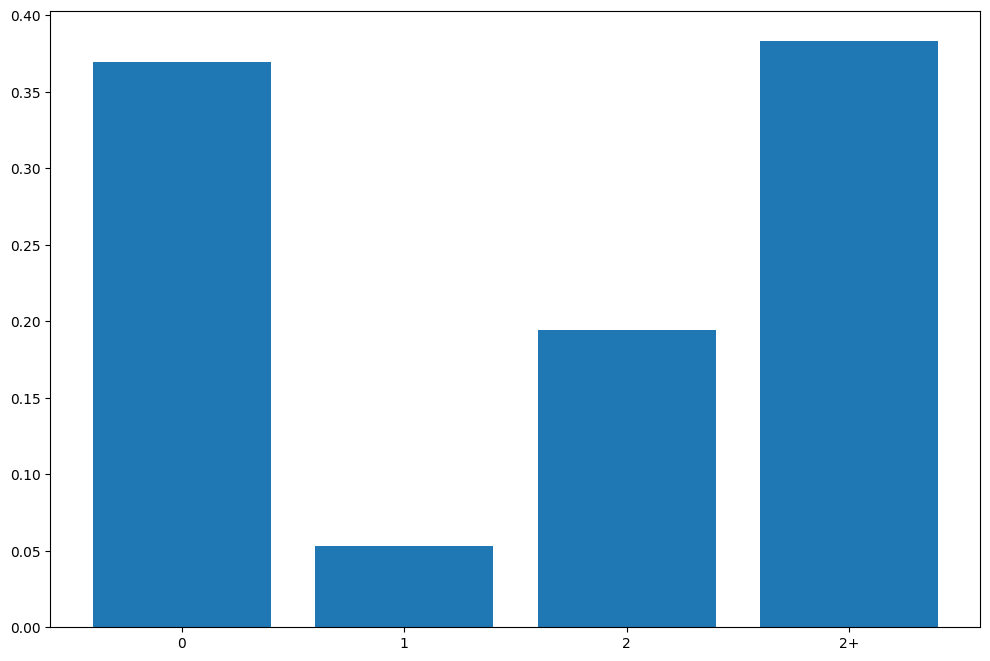

City: Barcelona
               personas
numero_viajes          
0              0.408866
1              0.051611
2              0.182489
2+             0.357034


/var/folders/d3/rdvhjvc52n99n0pgdzgxgtph0000gq/T/ipykernel_2317/2445987698.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_muni['personas'] = df_muni['personas']/best_pop[i]


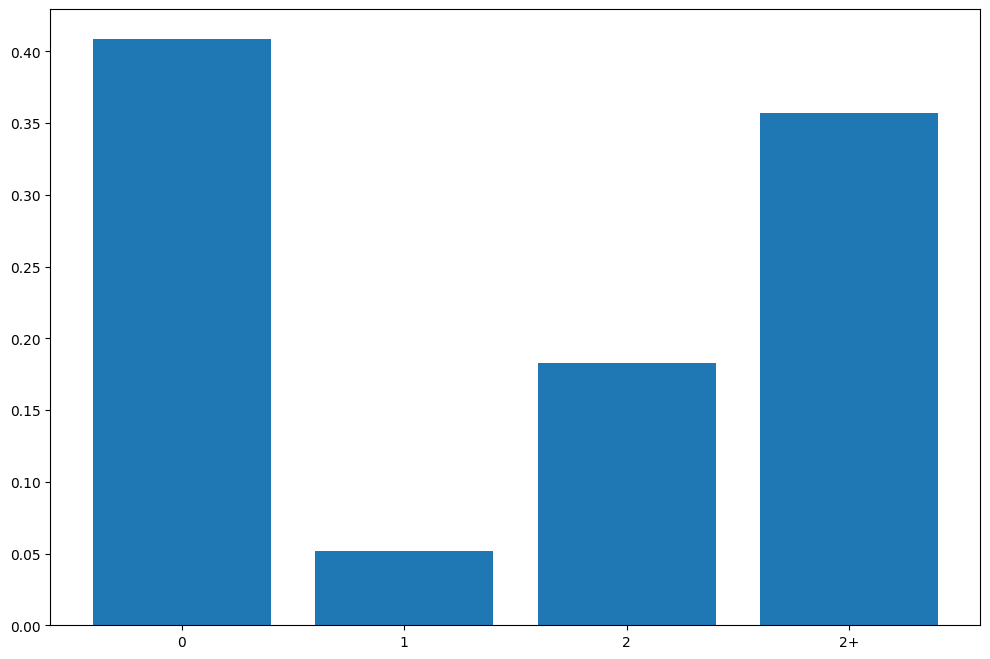

City: Valencia
               personas
numero_viajes          
0               0.34471
1               0.05398
2               0.20749
2+              0.39382


/var/folders/d3/rdvhjvc52n99n0pgdzgxgtph0000gq/T/ipykernel_2317/2445987698.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_muni['personas'] = df_muni['personas']/best_pop[i]


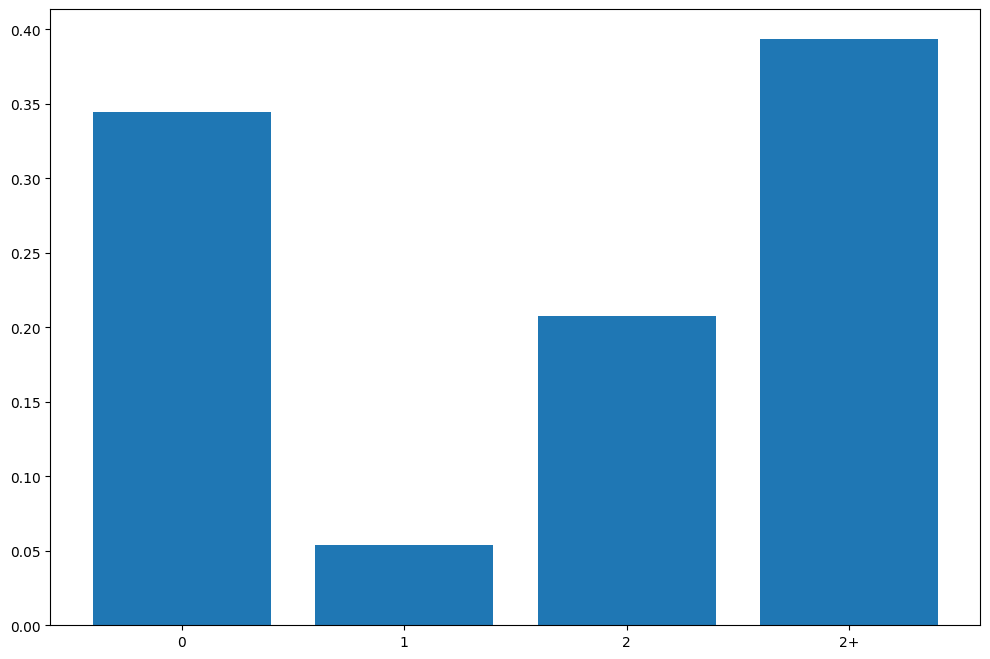

City: Siviglia
               personas
numero_viajes          
0              0.337894
1              0.059701
2              0.199100
2+             0.403304


/var/folders/d3/rdvhjvc52n99n0pgdzgxgtph0000gq/T/ipykernel_2317/2445987698.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_muni['personas'] = df_muni['personas']/best_pop[i]


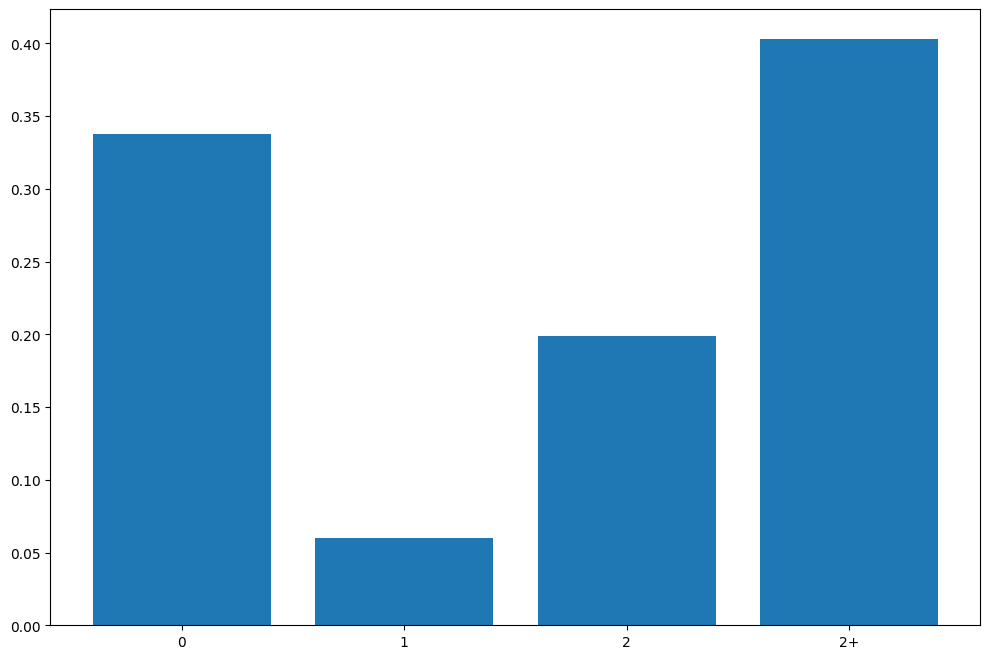

City: Zaragoza
               personas
numero_viajes          
0              0.287577
1              0.049524
2              0.213134
2+             0.449765


/var/folders/d3/rdvhjvc52n99n0pgdzgxgtph0000gq/T/ipykernel_2317/2445987698.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_muni['personas'] = df_muni['personas']/best_pop[i]


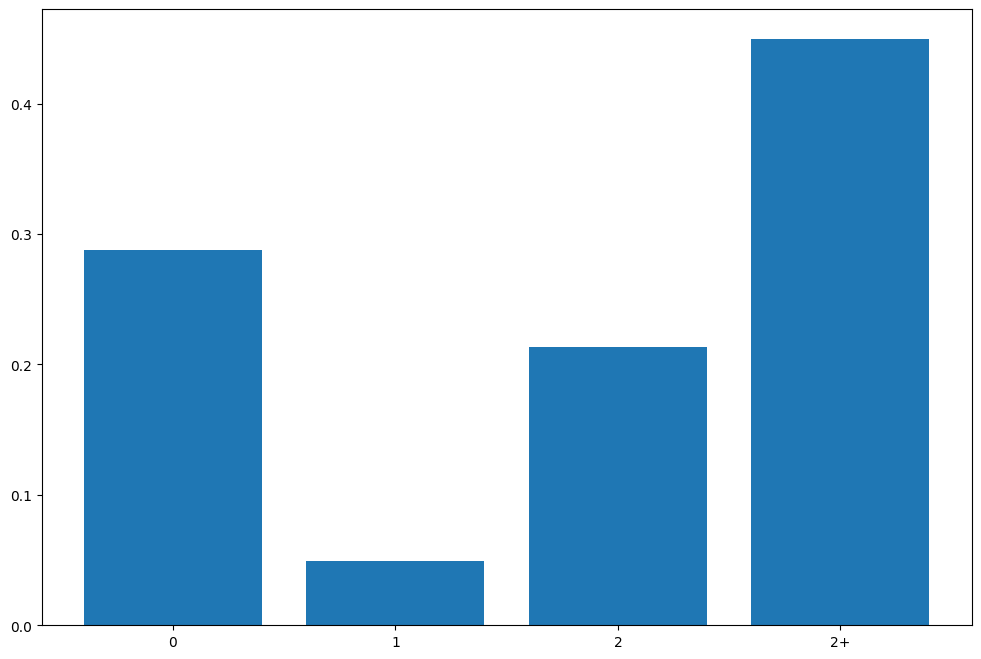

City: Malaga
               personas
numero_viajes          
0              0.300120
1              0.051052
2              0.201102
2+             0.447726


/var/folders/d3/rdvhjvc52n99n0pgdzgxgtph0000gq/T/ipykernel_2317/2445987698.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_muni['personas'] = df_muni['personas']/best_pop[i]


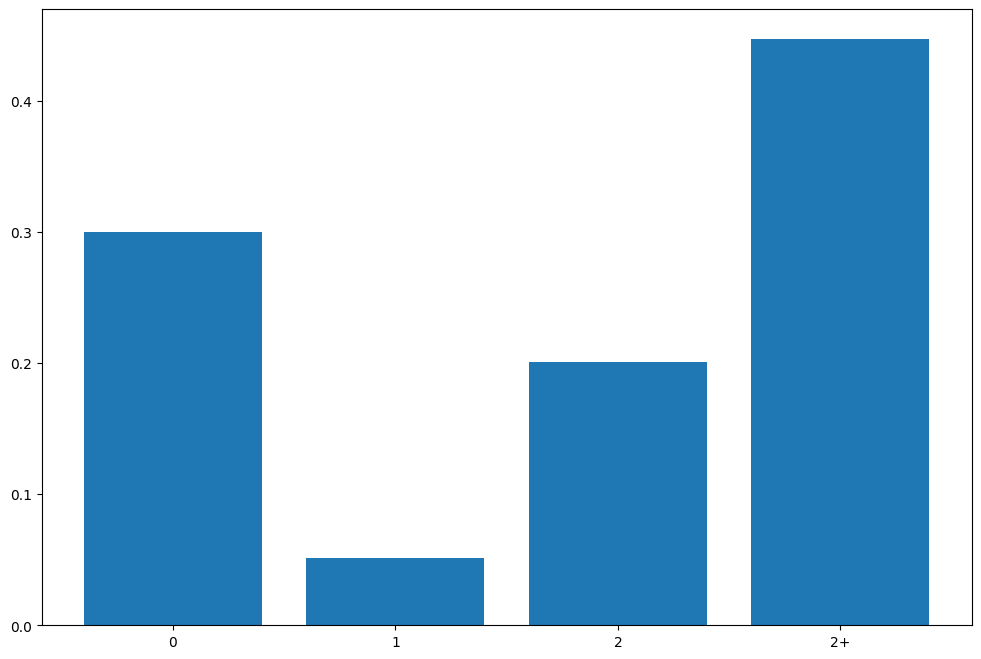

City: Murcia
               personas
numero_viajes          
0              0.305212
1              0.054501
2              0.186881
2+             0.453405


/var/folders/d3/rdvhjvc52n99n0pgdzgxgtph0000gq/T/ipykernel_2317/2445987698.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_muni['personas'] = df_muni['personas']/best_pop[i]


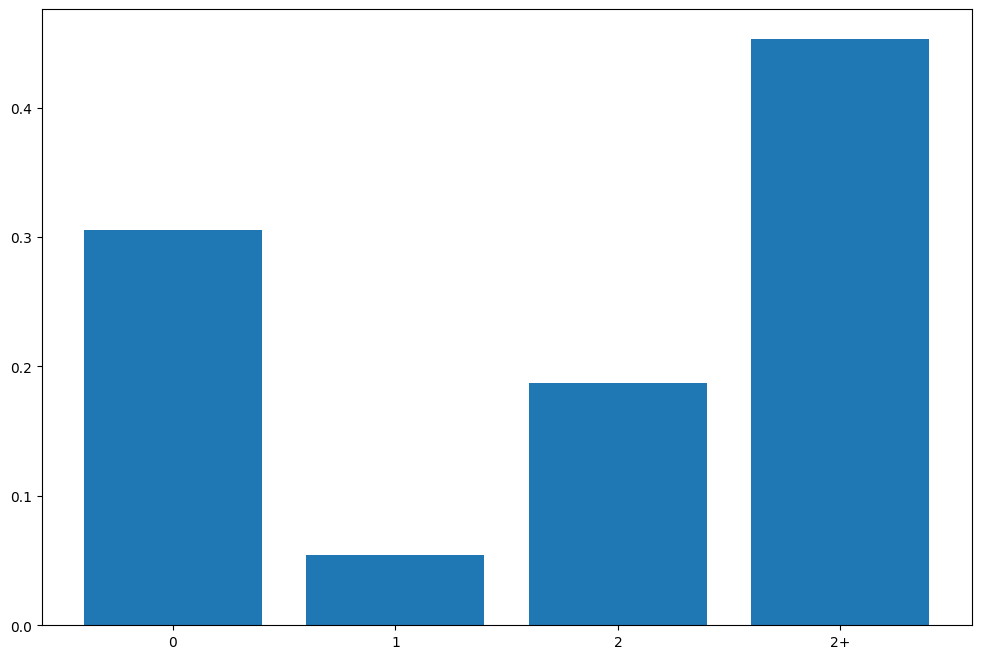

City: Maiorca
               personas
numero_viajes          
0              0.333601
1              0.043963
2              0.189947
2+             0.432488


/var/folders/d3/rdvhjvc52n99n0pgdzgxgtph0000gq/T/ipykernel_2317/2445987698.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_muni['personas'] = df_muni['personas']/best_pop[i]


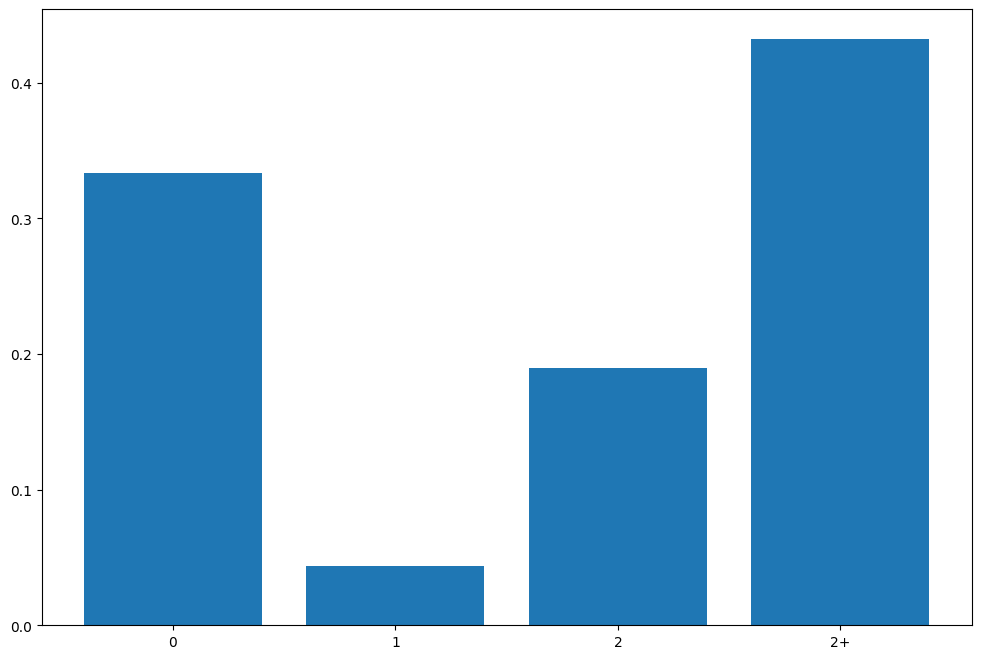

City: GranCanaria
               personas
numero_viajes          
0              0.287784
1              0.049316
2              0.189437
2+             0.473462


/var/folders/d3/rdvhjvc52n99n0pgdzgxgtph0000gq/T/ipykernel_2317/2445987698.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_muni['personas'] = df_muni['personas']/best_pop[i]


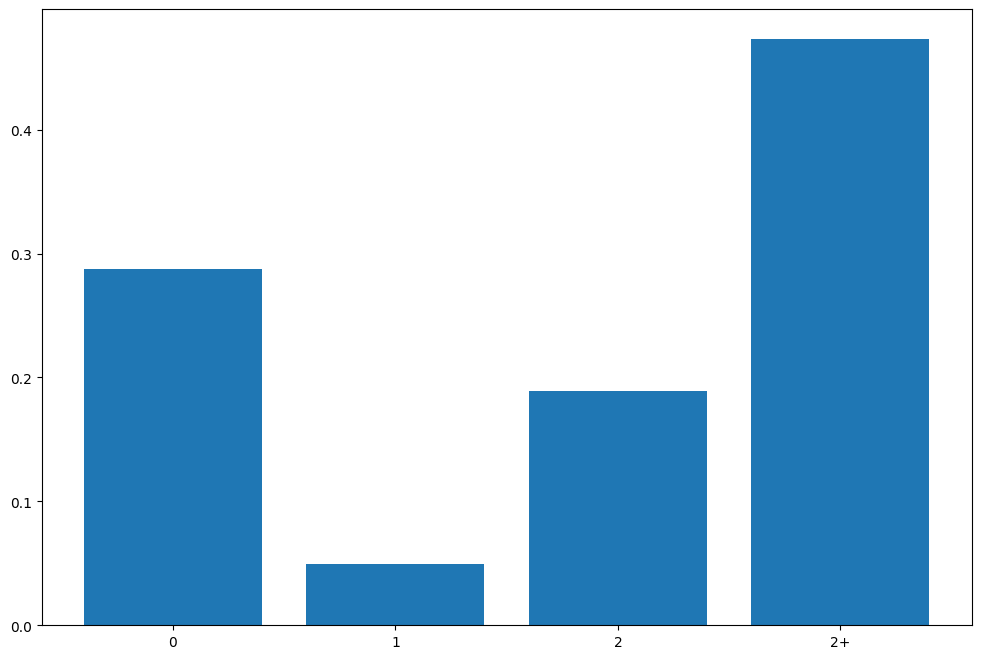

City: Bilbao
               personas
numero_viajes          
0              0.341119
1              0.041368
2              0.189545
2+             0.427968


/var/folders/d3/rdvhjvc52n99n0pgdzgxgtph0000gq/T/ipykernel_2317/2445987698.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_muni['personas'] = df_muni['personas']/best_pop[i]


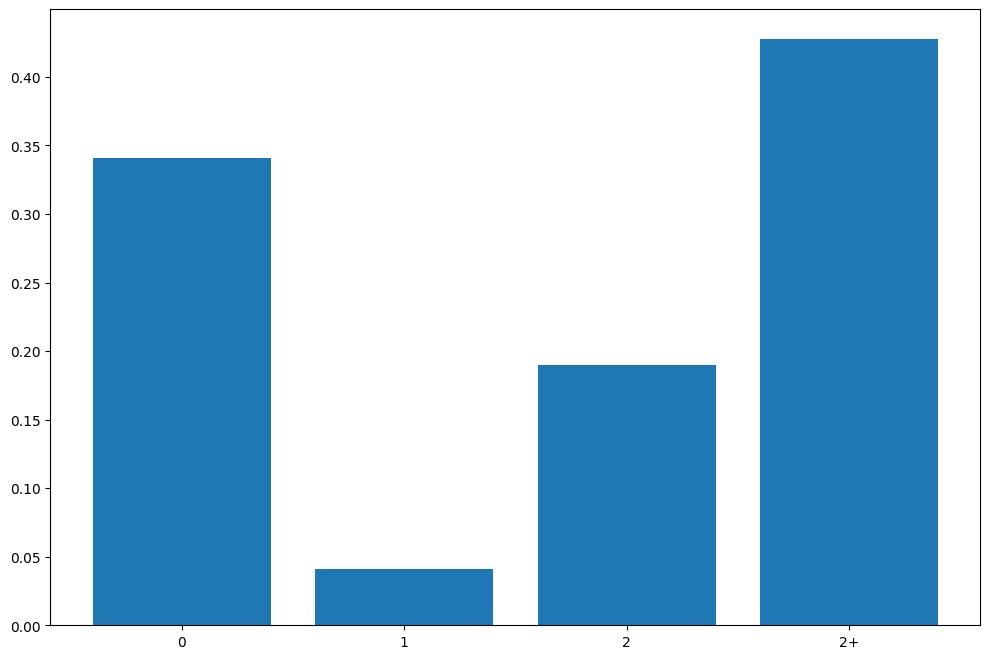

In [26]:
city_dict = dict.fromkeys(best_names, None)
x = df2['numero_viajes'].unique()
for i in range(len(best_muni)):
    name = best_names[i]
    print(f'City: {name}')
    m = best_muni[i]
    df_muni = df2.loc[df2['municipio']==m] 
    df_muni['personas'] = df_muni['personas']/best_pop[i]
    tmp = df_muni[['personas', 'numero_viajes']].groupby(by='numero_viajes').mean()
    tmp['personas'] = tmp['personas']/tmp['personas'].sum()
    print(tmp.head())
    plt.figure(figsize=(12,8))
    plt.bar(x, tmp['personas'].values)
    plt.show()
    city_dict[name] = tmp['personas']

Proportion of number of viajes per city (most popolous):

/var/folders/d3/rdvhjvc52n99n0pgdzgxgtph0000gq/T/ipykernel_2317/3607953343.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  zero.append(city_dict[d][0])
/var/folders/d3/rdvhjvc52n99n0pgdzgxgtph0000gq/T/ipykernel_2317/3607953343.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  one.append(city_dict[d][1])
/var/folders/d3/rdvhjvc52n99n0pgdzgxgtph0000gq/T/ipykernel_2317/3607953343.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


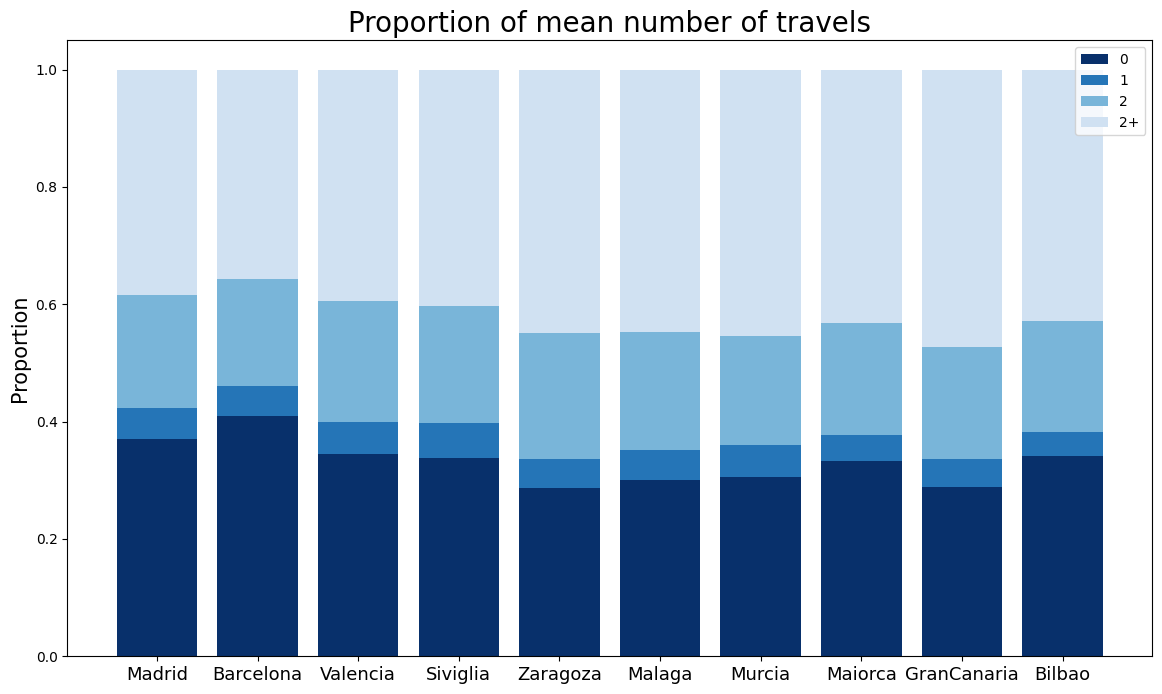

In [29]:
zero = []
one = []
two = []
two_plus = []
for d in best_names:
    zero.append(city_dict[d][0])
    one.append(city_dict[d][1])
    two.append(city_dict[d][2])
    two_plus.append(city_dict[d][3])
b_two = list(np.add(zero, one))
b_two_plus = list(np.add(b_two, two))

c = np.arange(1, 4 + 1)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
cmap.set_array([])


plt.figure(figsize=(14,8))
plt.bar(best_names, zero, label='0', color = cmap.to_rgba(6))
plt.bar(best_names, one, bottom=zero, label='1', color=cmap.to_rgba(3.2))
plt.bar(best_names, two, bottom=b_two, label='2', color=cmap.to_rgba(2.4))
plt.bar(best_names, two_plus, bottom=b_two_plus, label='2+', color=cmap.to_rgba(1.6))
plt.ylabel('Proportion', fontsize=15)
plt.legend()
plt.title('Proportion of mean number of travels', fontsize=20)
plt.xticks(best_names, fontsize=13)
plt.savefig('figures/mean_travels_city_hist.png')
plt.show()

In [97]:
print(prop_dict)
print(best_muni)
print(best_names)

{'28079': array([0.84182269, 0.15817731]), '08019': array([0.77415871, 0.22584129]), '46250': array([0.72115801, 0.27884199]), '41091': array([0.80149903, 0.19850097]), '50297': array([0.89244333, 0.10755667]), '29067': array([0.86137438, 0.13862562]), '30030': array([0.77771247, 0.22228753]), '07040': array([0.80293952, 0.19706048]), '35016': array([0.81932069, 0.18067931]), '48020': array([0.7178327, 0.2821673])}
['28079' '08019' '46250' '41091' '50297' '29067' '30030' '07040' '35016'
 '48020']
['Madrid', 'Barcelona', 'Valencia', 'Siviglia', 'Zaragoza', 'Malaga', 'Murcia', 'Maiorca', 'GranCanaria', 'Bilbao']
